# paper acceptance prediction
Aristoi

In [83]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import itertools
import gensim
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm


In [111]:
def preprocessing(s):
    s = re.sub("[0-9]+", "0", s)

    # リンク
    s = re.sub('http:.* ', 'http ', s)
    s = re.sub('https:.* ', 'https ', s)

    # 記号
    s = re.sub(r"[\"\'.,:;\(\)#\|\*\+\!\?#$&/\]\[\{\}]", "", s)
    s = re.sub("-", " ", s)

    """
    s = re.sub("[-:,]", " ", s)
    s = re.sub(".", "", s)
    s = re.sub("\?", " \?", s)
    s = re.sub('"', ' " ', s)
    s = re.sub('\(', ' \( ', s)
    s = re.sub('\)', ' \) ', s)
    s = re.sub("\n", " ")
    s = re.sub("\r", " ")
    s = re.sub("\u3000", " ")  # 全角スペース
    """

    # 固有名詞等の他は小文字化
    if(sum(map(str.islower, s)) >= 2):
        pass
    else:
        s = s.lower()

    s = re.split(" ", s)
    s = [e for e in s if e != ""]
    return s


In [159]:
class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx])
        y = torch.tensor(self.y[idx])
        return X, y

def collate_fn(batch):
    sequences = [x[0] for x in batch]
    y = torch.from_numpy(np.array([x[1] for x in batch]))
    x = pad_sequence(sequences, batch_first=True, padding_value=0)
    return x, y

class Model(nn.Module):
    def __init__(self, emb_dim, hidden_dim, output_dim, padding_idx, emb_weights):
        super().__init__()
        self.hidden_dim = hidden_dim
        DROPOUT = 0.5

        self.emb = nn.Embedding.from_pretrained(
            emb_weights, padding_idx=padding_idx
        )
        self.drop1 = nn.Dropout(DROPOUT)
        self.rnn = nn.LSTM(
            input_size = emb_dim,
            hidden_size = hidden_dim,
            num_layers = 4,
            batch_first=True,
            bias=True
        )
        self.drop2 = nn.Dropout(DROPOUT)
        self.l1 = nn.Linear(
            in_features = hidden_dim,
            out_features = output_dim,
            bias = True
        )

    def forward(self, x, h_0=None):
        x = self.emb(x)
        x = self.drop1(x)
        x, h = self.rnn(x, h_0)
        x = x[:, -1, :]
        x = self.drop2(x)
        x = self.l1(x)
        return x


In [160]:
def train_loop(data, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0.0

    for x, y in tqdm(data):
        size = len(data.dataset)
        
        optimizer.zero_grad()
        # x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(-1).sum().item())

    total_loss /= size
    correct /= size
    return total_loss, correct


In [151]:
# データ読み込み
emb_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

train_filename = "train_data.csv"
df_train = pd.read_csv(train_filename, index_col="id")
test_filename = "test_data.csv"
df_test = pd.read_csv(test_filename, index_col="id")

In [161]:
# text2id

train_text = df_train["title"].str.cat(sep="") + df_train["abstract"].str.cat(sep="")
train_words = preprocessing(train_text)
words_freq = Counter(itertools.chain(train_words))

word_to_id = {}
for i, word_uniq in enumerate(words_freq.most_common(), start=1):
    if(word_uniq[1] < 2): 
        break
    word_to_id.update({word_uniq[0]: i})

print(len(word_to_id))

def get_id_list(words):
    ids = []
    for word in words:
        if(word in word_to_id.keys()):
            id = word_to_id[word]
        else:
            id = 0
        ids.append(id)
    return ids

14798


In [162]:
# データ整形
x_train = "title " + df_train["title"] +" abstract " + df_train["abstract"]
x_train = x_train.map(preprocessing)
x_train = x_train.map(get_id_list)
x_train = np.array(x_train)

y_train = df_train["y"]
y_train = np.array(y_train)

x_test = "title " + df_test["title"] +" abstract " + df_test["abstract"]
x_test = x_test.map(preprocessing)
x_test = x_test.map(get_id_list)
x_test = np.array(x_test)

In [163]:
BATCH_SIZE = 1
train_dataset = Dataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

VOCAB_SIZE = len(word_to_id)+1
PADDING_IDX = 0
EMB_DIM = 300
HIDDEN_DIM = 50
OUTPUT_DIM = 4
LEARNING_RATE = 0.01
EPOCH_SIZE = 30

In [164]:
# 学習済み単語ベクトルの取得
weights = np.zeros((VOCAB_SIZE, EMB_DIM))
words_in_pretrained = 0
for i, word in enumerate(word_to_id.keys()):
    try:
        weights[i] = emb_model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.1, size=(EMB_DIM,))
weights = torch.from_numpy(weights.astype((np.float32)))


In [165]:
model = Model(emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, padding_idx=PADDING_IDX, emb_weights=weights)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# 学習
train_loss_history = []
train_acc_history = []
for i in range(EPOCH_SIZE):
    print("Epoch:", i+1, "--------------------------")
    loss, acc = train_loop(train_loader, model, loss_fn, optimizer)
    print("train_acc: ", acc)
    train_loss_history.append(loss)
    train_acc_history.append(acc)


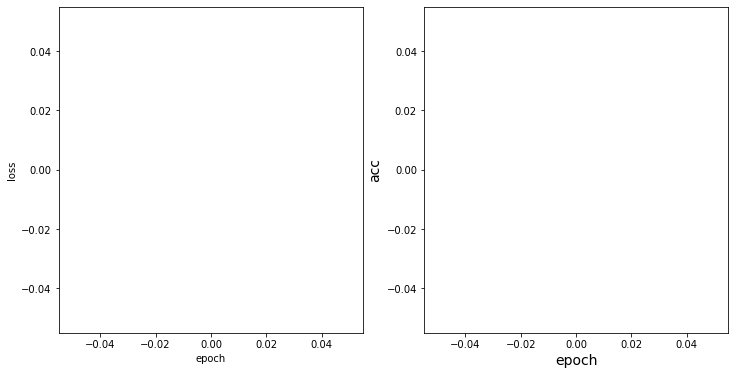

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(train_loss_history)
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")


axes[1].plot(train_acc_history)
axes[1].set_xlabel("epoch", size=14)
axes[1].set_ylabel("acc", size=14)

fig.savefig("90.png")


In [ ]:
test_predicted = model.predict(test_X)
submit_df = pd.DataFrame({"y": test_predicted})
submit_df.reset_index(drop=True)
submit_df.index += 1
submit_df.index.name = "id"
submit_df.to_csv("submission.csv")